In [1]:
!pip install ray

#Import Libraries
import numpy as np
import glob
import pathlib
import pandas as pd
from functools import partial
import shutil
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt



import torch
#import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable



import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import AsyncHyperBandScheduler

In [2]:
torch.manual_seed(1)

In [3]:
#Custom Model 1

class model1(nn.Module):
    def __init__(self,numClasses = 0):
        super(model1,self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=10,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=10)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=4, stride = 2)
        
        self.conv2=nn.Conv2d(in_channels=10,out_channels=24,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(num_features=24)
        self.relu2=nn.ReLU()
    
        self.conv3=nn.Conv2d(in_channels=24,out_channels=32,kernel_size=3,stride=1,padding=1)
        #self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        
        self.pool2=nn.MaxPool2d(kernel_size=3, stride = 2)
    
        self.fc=nn.Linear(in_features=32*24*24,out_features=numClasses)
        
        
        
    #Feed forwad    
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool1(output)
            
        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        #output=self.bn3(output)
        output=self.relu3(output)
        output=self.pool2(output)
            
            
        output=output.view(-1,32*24*24)
        output=self.fc(output)
            
        return output

In [4]:
class CustomDataset():
    def __init__(self, root):
        self.rootPath = root
        self.trainPath = root + 'train/'
        self.testPath = root + 'test/'
        self.trainLabelPath = root + 'train.csv'
        self.trainDF = pd.read_csv(self.trainLabelPath)
        self.dfLength = len(self.trainDF)
        self.labels = self.trainDF['Label'].unique()
        self.numLabels = len(self.labels)
        self.device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
        

        
    def trainEvalSplit(self, fraction = 0.8):
        randomSeed = 1
        randomState = np.random.RandomState(randomSeed)
        self.trainData = self.trainDF.sample(frac=fraction, random_state=randomState)
        self.evalData = self.trainDF.loc[~self.trainDF.index.isin(self.trainData.index)]
        return self.trainData, self.evalData
        
    def createClassFolder(self, destination):
        classFolders = ['trainClasses/', 'evalClasses/']
        self.classFolderPath = {'train' : destination + classFolders[0],
                                'eval' : destination + classFolders[1],
                               }
        for folderName in classFolders:
            path = destination + folderName
            if not os.path.exists(path):
                os.mkdir(path)
            
            if folderName == classFolders[0]:
                data = self.trainData
            elif folderName == classFolders[1]:
                data = self.evalData

            for fileName, className in data.values:
                # Create subdirectory with `class_name`
                if not os.path.exists(path + str(className)):
                    os.mkdir(path + str(className))
                sourcePath = self.trainPath + str(fileName)
                destinationPath = path + str(className) + '/' + str(fileName)
                try:
                    shutil.copy(sourcePath, destinationPath)
                except:
                    print('Error in Creating Class Folders')
                    
        trainCount=len(glob.glob(self.classFolderPath.get('train') + '**/*.png'))
        evalCount=len(glob.glob(self.classFolderPath.get('eval') + '**/*.png'))
        print(f'Images for Training: {trainCount}\nImages for Evaluation: {evalCount}')
        

    def classBalancingWeights(self):
        self.classWeights = {}
        for label in self.labels:
            numSamplesInLabel = np.sum(self.trainDF['Label'].tolist() == label)
            weight = self.dfLength / (numSamplesInLabel * self.numLabels)
            self.classWeights[label] = weight
        #print("Class weights for balancing:", self.classWeights)
        
        #Convert to Tensor
        self.classWeights = torch.tensor(list(self.classWeights.values()))
        if self.device == torch.device('cuda'): 
            self.classWeights = self.classWeights.type(torch.FloatTensor).to(self.device)
        else:
            self.classWeights = self.classWeights.type(torch.FloatTensor)
        return self.classWeights


    def getClassDistribution(self):
        return self.trainDF['Label'].value_counts()
                    
                    


In [5]:
rootPath = '/kaggle/input/deep-learning-for-msc-2022-23/'
classFolderPath = '/kaggle/working/'

In [6]:
#Create Object
dataset = CustomDataset(rootPath)
device = dataset.device

print('\nClass Distribution:')
print(dataset.getClassDistribution())

#Split Train and Eval Dataset
trainDataset, evalDataset = dataset.trainEvalSplit(0.8)

#Create Train, Eval Class Folders
dataset.createClassFolder(destination = classFolderPath)


Class Distribution:
1    3462
3    2690
0     729
2     679
Name: Label, dtype: int64
Images for Training: 6048
Images for Evaluation: 1512


In [7]:
#Transformer for Training Model

trainTransformer = transforms.Compose([
    transforms.RandomRotation(degrees = 180),
    transforms.Resize((100,100)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [8]:
#Define Optimizer
def modelOptimizer(model, learningRate):
    optimizer = optim.SGD(model.parameters(), lr = learningRate)
    #optimizer = optim.Adam(model.parameters(), lr = learningRate)
    return optimizer


#Define Loss Function
def getLossFunction(classBalancingWeights):
    lossFunction = nn.CrossEntropyLoss(weight = classBalancingWeights, reduction = 'mean')
    return lossFunction

# ****RAY TUNING MODEL-1****

In [9]:
def tuneModel1(config):    
    
    # Initialize the model and the optimizer
    CNNModelTune = model1(dataset.numLabels).to(device)
    
    lossFunction = getLossFunction(dataset.classBalancingWeights())
     
    optimizer = modelOptimizer(model = CNNModelTune, 
                               learningRate = config["learningRate"]
                              )
    

    trainLoader=DataLoader(torchvision.datasets.ImageFolder(dataset.classFolderPath.get('train'), transform=trainTransformer),
                            batch_size = config["batchSize"], shuffle=True 
                           )
    
    evalLoader=DataLoader(torchvision.datasets.ImageFolder(dataset.classFolderPath.get('eval'),transform=trainTransformer),
                          batch_size = config["batchSize"], shuffle=True
                         )
    
    for epoch in range(config["epochs"]):
        trainLoss = 0.0
        trainAccuracy = 0
        
        CNNModelTune.train()
                
        for i, (images,labels) in enumerate(trainLoader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
                
            optimizer.zero_grad()
            
            outputs = CNNModelTune(images)
            loss = lossFunction(outputs,labels.to("cuda"))
            loss.backward()
            optimizer.step()
            
            _,prediction = torch.max(outputs.data,1)
            
            trainLoss += loss.cpu().data * images.size(0)
            trainAccuracy += int(torch.sum(prediction == labels.data))

        trainAccuracy /= len(trainLoader.dataset)
        trainLoss /= len(trainLoader.dataset)
        
        
        # Calculate validation loss
        CNNModelTune.eval()
        evalLoss = 0.0
        evalAccuracy = 0
        
        
        with torch.no_grad():
            
            for i, (images,labels) in enumerate(evalLoader):
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                    labels = Variable(labels.cuda())
                outputs = CNNModelTune(images)
                
                loss = lossFunction(outputs,labels.to("cuda"))
                
                _,prediction = torch.max(outputs.data,1)
                
                evalLoss += loss.item() * images.size(0)
                evalAccuracy += int(torch.sum(prediction == labels.data))

        evalLoss /= len(evalLoader.dataset)
        evalAccuracy /= len(evalLoader.dataset)

        # Report intermediate results
        tune.report(loss=(evalLoss), accuracy=(evalAccuracy))

    return {"loss": evalLoss, "accuracy": evalAccuracy}

In [10]:
# Define the hyperparameters to tune and the search space
config = {
    "learningRate": tune.loguniform(1e-5, 1e-1),
    "batchSize": tune.choice([16, 32, 64, 128]),
    "epochs": tune.choice([15, 30, 40, 50])
}

In [11]:

os.environ["GRPC_ENABLE_FORK_SUPPORT"] = "0"

# Shut down any existing Ray runtime
ray.shutdown()

# Initialize a new Ray runtime
ray.init()

# Set up the hyperparameter search

resources_per_trial = {"cpu": 2}

if torch.cuda.is_available():
    resources_per_trial["gpu"] = 2
    
    

analysis = tune.run(
    tuneModel1,
    config=config,
    metric="loss",
    mode="min",
    num_samples=20,
    search_alg=HyperOptSearch(),
    scheduler=AsyncHyperBandScheduler(),
    resources_per_trial=resources_per_trial,
    verbose=1,
    local_dir="/results"
)

# Print the best configuration
print("Best configuration: ", analysis.best_config)

2023-03-27 12:29:12,135	INFO tune.py:763 -- Total run time: 1715.43 seconds (1714.74 seconds for the tuning loop).


Best configuration:  {'learningRate': 0.007167415833585117, 'batchSize': 16, 'epochs': 40}


In [12]:
#Best Parameters

learningRate = analysis.best_config.get('learningRate')
epochCount = analysis.best_config.get('epochs')
BATCH_SIZE = analysis.best_config.get('batchSize')

In [13]:
CNNModel = model1(dataset.numLabels).to(device)

optimizer = modelOptimizer(model = CNNModel, 
                           learningRate = learningRate
                          )

lossFunction = getLossFunction(dataset.classBalancingWeights())


trainLoader = DataLoader(torchvision.datasets.ImageFolder(dataset.classFolderPath.get('train'), transform=trainTransformer),
                        batch_size = BATCH_SIZE, shuffle=True 
                       )

evalLoader = DataLoader(torchvision.datasets.ImageFolder(dataset.classFolderPath.get('eval'),transform=trainTransformer),
                      batch_size = BATCH_SIZE, shuffle=True
                     )


In [14]:
#Model training and saving best model

bestAccuracy=0.0
# Loss Accuracy Curve
lossValues = []
accuracyValues = []

for epoch in range(epochCount):
    
    #Evaluation and training on training dataset
    CNNModel.train()
    trainAccuracy=0.0
    trainLoss=0.0
    
    
    for i, (images,labels) in enumerate(trainLoader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = CNNModel(images)
        loss = lossFunction(outputs,labels.to("cuda"))
        loss.backward()
        optimizer.step()

        _,prediction = torch.max(outputs.data,1)

        trainLoss += loss.cpu().data * images.size(0)
        trainAccuracy += int(torch.sum(prediction == labels.data))

    trainAccuracy /= len(trainLoader.dataset)
    trainLoss /= len(trainLoader.dataset)

    
    
    # Evaluating model on Evaluation dataset

    CNNModel.eval()
    evalLoss = 0.0
    evalAccuracy = 0
    # Used for Confusion Matrix
    trueLabels = []
    predLabels = []

    with torch.no_grad():
        for i, (images,labels) in enumerate(evalLoader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            outputs = CNNModel(images)
            loss = lossFunction(outputs,labels.to("cuda"))

            _,prediction = torch.max(outputs.data,1)
            trueLabels.extend(labels.cpu().numpy())
            predLabels.extend(prediction.cpu().numpy())

            evalLoss += loss.item() * images.size(0)
            evalAccuracy += int(torch.sum(prediction == labels.data))
            
    evalLoss /= len(evalLoader.dataset)
    evalAccuracy /= len(evalLoader.dataset)
    # Loss Accuracy Curve
    accuracyValues.append(evalAccuracy)
    lossValues.append(evalLoss)
    
    print(f'Epoch: {epoch}\nTrain Loss: {trainLoss} Train Accuracy: {trainAccuracy}\nEvaluation Loss: {evalLoss} Evaluation Accuracy: {evalAccuracy}\n')
    
    #Save the best model
    if evalAccuracy > bestAccuracy:
        torch.save(CNNModel.state_dict(),'bestModel.model1')
        bestAccuracy = evalAccuracy
        # Used for Confusion Matrix
        CMTrueLabels = np.array(trueLabels)
        CMPredLabels = np.array(predLabels)

Epoch: 0
Train Loss: 0.6891382336616516 Train Accuracy: 0.697255291005291
Evaluation Loss: 0.5121126205675186 Evaluation Accuracy: 0.828042328042328

Epoch: 1
Train Loss: 0.4824208915233612 Train Accuracy: 0.7858796296296297
Evaluation Loss: 1.6021307003561152 Evaluation Accuracy: 0.6832010582010583

Epoch: 2
Train Loss: 0.4373031556606293 Train Accuracy: 0.8121693121693122
Evaluation Loss: 0.631153614748092 Evaluation Accuracy: 0.7361111111111112

Epoch: 3
Train Loss: 0.4246276021003723 Train Accuracy: 0.8176256613756614
Evaluation Loss: 0.3648963401872645 Evaluation Accuracy: 0.8128306878306878

Epoch: 4
Train Loss: 0.39360857009887695 Train Accuracy: 0.8343253968253969
Evaluation Loss: 0.3243357130774745 Evaluation Accuracy: 0.8604497354497355

Epoch: 5
Train Loss: 0.3714633882045746 Train Accuracy: 0.8449074074074074
Evaluation Loss: 0.36982607362525804 Evaluation Accuracy: 0.9093915343915344

Epoch: 6
Train Loss: 0.36281129717826843 Train Accuracy: 0.845734126984127
Evaluation Los

In [15]:
print(f"The best accuracy is {bestAccuracy*100} %")

The best accuracy is 91.46825396825396 %


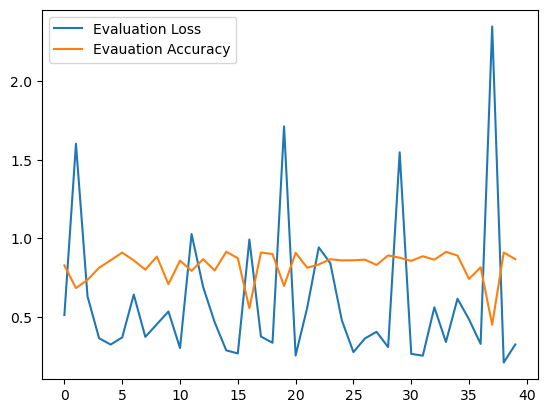

In [16]:
# Plot the loss and accuracy curves
plt.plot(lossValues, label='Evaluation Loss')
plt.plot(accuracyValues, label='Evauation Accuracy')
plt.legend()
plt.show()

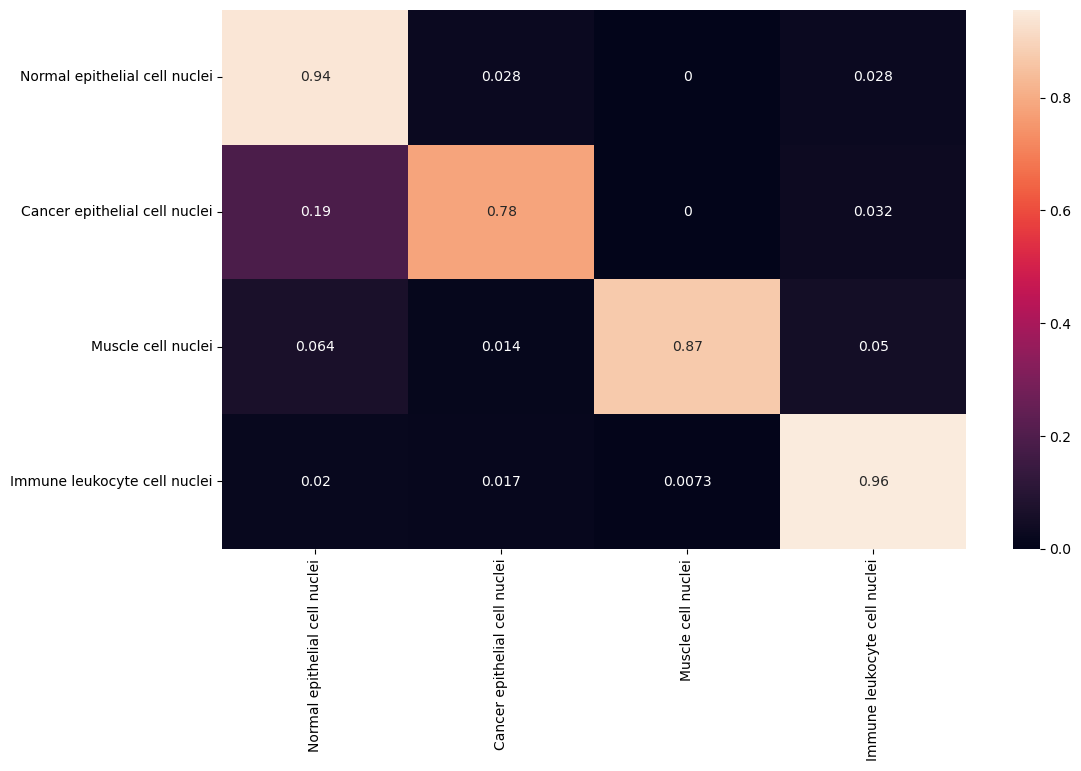

In [17]:
# constant for classes
cell = {
    '0' : 'Normal epithelial cell nuclei',
    '1' : 'Cancer epithelial cell nuclei',
    '2' : 'Muscle cell nuclei',
    '3' : 'Immune leukocyte cell nuclei',
}
classes = list(cell.values())


# Build confusion matrix
cf_matrix = confusion_matrix(trueLabels, predLabels)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [18]:
predPath = r'/kaggle/input/deep-learning-for-msc-2022-23/test'

In [19]:
checkpoint=torch.load('bestModel.model1')
model=model1(dataset.numLabels)
model.load_state_dict(checkpoint)
model.eval()

model1(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=18432, out_features=4, bias=True)
)

In [20]:
transformerPrediction = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor() ])

In [21]:
from PIL import Image

def prediction(imgPath,transformerPrediction):
    
    image=Image.open(imgPath)
    imageTensor=transformerPrediction(image).float()
    imageTensor=imageTensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        imageTensor.cuda()
        
    input=Variable(imageTensor)
    output=model(input)
    index=output.data.numpy().argmax()
    pred=dataset.labels[index]
    return pred

In [22]:
imagesPath = glob.glob(predPath+'/*.png')

In [23]:
predictions={}
predictions['Filename'] = 'Label'

for i in imagesPath:
    predictions[i[49:58]]=prediction(i,transformerPrediction)
    
print('Predictions: \n',predictions)

Predictions: 
 {'Filename': 'Label', '14127.png': 1, '11396.png': 0, '14260.png': 1, '12329.png': 1, '13412.png': 1, '14325.png': 3, '13139.png': 1, '12743.png': 3, '14990.png': 1, '10760.png': 1, '12867.png': 1, '13570.png': 1, '12684.png': 1, '13612.png': 1, '12204.png': 1, '13159.png': 0, '10188.png': 3, '11953.png': 1, '12956.png': 1, '12139.png': 1, '12727.png': 3, '14516.png': 3, '11572.png': 1, '11070.png': 3, '11927.png': 1, '10107.png': 3, '13744.png': 1, '13907.png': 3, '14555.png': 1, '12470.png': 3, '13513.png': 1, '13964.png': 2, '11901.png': 0, '11711.png': 1, '10696.png': 1, '11506.png': 1, '14202.png': 1, '13767.png': 1, '13009.png': 2, '14348.png': 3, '10124.png': 1, '13691.png': 1, '10316.png': 1, '11246.png': 3, '14502.png': 0, '13679.png': 3, '13556.png': 1, '14750.png': 1, '14993.png': 1, '11695.png': 3, '10106.png': 0, '13018.png': 1, '12631.png': 1, '11196.png': 1, '10496.png': 1, '13908.png': 1, '13644.png': 3, '13314.png': 3, '13337.png': 3, '10149.png': 1, '13

In [24]:
import csv

predictionFile = open("predictionsModel-1.csv", "w")

write = csv.writer(predictionFile)
for key, value in predictions.items():
    write.writerow([key, value])

predictionFile.close()

# ****MODEL 2****

In [25]:
import numpy as np
import pandas as pd
import cv2, os
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets

#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
#Defining the Directories
train_data_dir = dataset.classFolderPath.get('train')
test_data_dir = dataset.classFolderPath.get('eval')
pred_data_dir = "/kaggle/input/deep-learning-for-msc-2022-23/test"

In [27]:
# Performing the Image Transformation and Data Augmentation on the 
# train dataset and transformation on Validation Dataset

# convert data to a normalized torch.FloatTensor

transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.3,0.4,0.4,0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.425,0.415,0.405),(0.205,0.205,0.205))
])

# Augmentation on test images not needed
transform_tests = torchvision.transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [28]:
#Downloading the InceptionV3 Model with their pretrained weights

model = models.inception_v3(pretrained=True)
model.parameters

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

<bound method Module.parameters of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2

In [29]:
#Defining the Model Function.
# Lets freeze all layers and change just a few layers to match our requirements

def get_model():
    model = models.inception_v3(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128,4))
    model.aux_logits = False
    return model.to(device)

In [30]:
!pip install torchsummary

from torchsummary import summary

input_shape = (3,300,300)
summary(model.to(device), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [31]:
#Creating the Utlity function to get the Losses and Accuracies for Train and Validation Dataset 

def train_batch(x, y, model, opt, loss_fn):
    output = model(x)
    batch_loss = loss_fn(output, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()


In [32]:
# using ImageFolder function for fetching data from directory
train_data = datasets.ImageFolder(root=dataset.classFolderPath.get('train'),transform=transform)
test_data = datasets.ImageFolder(root=dataset.classFolderPath.get('eval'),transform=transform_tests)


In [33]:
def tuneModel2(config):    
    
    # Initialize the model and the optimizer
    model = get_model().to(device)
    
    lossFunction = nn.CrossEntropyLoss()
     
    optimizer = torch.optim.Adam(model.parameters(), lr = config["learningRate"])
    

    trainLoader=DataLoader(train_data,batch_size=config["batchSize"],drop_last=True,shuffle=True,num_workers=2)
    
    evalLoader=DataLoader(test_data, batch_size =config["batchSize"], drop_last=True,shuffle=True,num_workers=2)
    
    # Start the Model Training and save the Losses and Accuracies of Both train and validation

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(config["epochs"]):
        #print(epoch)
        train_epoch_losses, train_epoch_accuracies = [], []
        for ix, batch in enumerate(iter(trainLoader)):
    #         print(f"ix - {ix}, {batch}")
            x, y = batch
    #         print(f"type of x - {type(x)}, type of y - {type(y)}")
            x, y= x.to(device), y.to(device)
            batch_loss = train_batch(x, y, model, optimizer, lossFunction)
            is_correct = accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)
            train_epoch_losses.append(batch_loss)        
        train_epoch_loss = np.array(train_epoch_losses).mean()
        train_epoch_accuracy = np.mean(train_epoch_accuracies)        

        for ix, batch in enumerate(iter(evalLoader)):
            x, y = batch
            x, y= x.to(device), y.to(device)
            val_is_correct = accuracy(x, y, model)
            validation_loss = val_loss(x, y, model, lossFunction)    
            val_epoch_accuracy = np.mean(val_is_correct)

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_losses.append(validation_loss)
        val_accuracies.append(val_epoch_accuracy)
        
        
        # Report intermediate results
        tune.report(loss=(validation_loss), accuracy=(val_epoch_accuracy))

    return {"loss": validation_loss, "accuracy": val_epoch_accuracy}

In [34]:
# Define the hyperparameters to tune and the search space
config = {
    "learningRate": tune.loguniform(1e-4, 1e-1),
    "batchSize": tune.choice([16, 32]),
    "epochs": tune.choice([10, 20])
}

In [35]:
os.environ["GRPC_ENABLE_FORK_SUPPORT"] = "0"

# Shut down any existing Ray runtime
ray.shutdown()

# Initialize a new Ray runtime
ray.init()

# Set up the hyperparameter search

resources_per_trial = {"cpu": 2}

if torch.cuda.is_available():
    resources_per_trial["gpu"] = 2
    
    

analysis = tune.run(
    tuneModel2,
    config=config,
    metric="loss",
    mode="min",
    num_samples=20,
    search_alg=HyperOptSearch(),
    scheduler=AsyncHyperBandScheduler(),
    resources_per_trial=resources_per_trial,
    verbose=1,
    local_dir="/results"
)

# Print the best configuration
print("Best configuration: ", analysis.best_config)

(tuneModel2 pid=2975) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(tuneModel2 pid=2975)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(tuneModel2 pid=2975) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
(tuneModel2 pid=2975)   warnings.warn(msg)
(tuneModel2 pid=4837) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please

Best configuration:  {'learningRate': 0.000610393265479415, 'batchSize': 16, 'epochs': 20}


In [36]:
#Best Parameters


#Best={'learningRate': 0.0008156846002208501, 'batchSize': 16, 'epochs': 22}


learningRate = analysis.best_config.get('learningRate')
epochCount = analysis.best_config.get('epochs')
BATCH_SIZE = analysis.best_config.get('batchSize')


'''learningRate = Best.get('learningRate')
epochCount = Best.get('epochs')
BATCH_SIZE = Best.get('batchSize')'''

"learningRate = Best.get('learningRate')\nepochCount = Best.get('epochs')\nBATCH_SIZE = Best.get('batchSize')"

In [37]:
# Initialize the model and the optimizer
model = get_model().to(device)

lossFunction = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)


trainLoader=DataLoader(train_data,batch_size=BATCH_SIZE,drop_last=True,shuffle=True,num_workers=2)
    
evalLoader=DataLoader(test_data, batch_size =BATCH_SIZE, drop_last=True,shuffle=True,num_workers=2)


# Start the Model Training and save the Losses and Accuracies of Both train and validation

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
bestAccuracy = 0
for epoch in range(epochCount):
    #print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trainLoader)):
#         print(f"ix - {ix}, {batch}")
        x, y = batch
#         print(f"type of x - {type(x)}, type of y - {type(y)}")
        x, y= x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, lossFunction)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print('Epoch:',epoch,'Train Loss:',train_epoch_loss,'Train Accuracy:',train_epoch_accuracy)
    

    for ix, batch in enumerate(iter(evalLoader)):
        x, y = batch
        x, y= x.to(device), y.to(device)
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, lossFunction)    
        val_epoch_accuracy = np.mean(val_is_correct)
        
    print('Epoch:',epoch,'Validation Loss:',validation_loss,'Validation Accuracy:',val_epoch_accuracy)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    
    #Save the best model
    if val_epoch_accuracy > bestAccuracy:
        torch.save(model.state_dict(),'bestModel.model2')
        bestAccuracy = val_epoch_accuracy

Epoch: 0 Train Loss: 0.5167557479488472 Train Accuracy: 0.8154761904761905
Epoch: 0 Validation Loss: 0.3127373158931732 Validation Accuracy: 0.875
Epoch: 1 Train Loss: 0.3713970923273967 Train Accuracy: 0.8644179894179894
Epoch: 1 Validation Loss: 0.3810845911502838 Validation Accuracy: 0.875
Epoch: 2 Train Loss: 0.3292771105570768 Train Accuracy: 0.8857473544973545
Epoch: 2 Validation Loss: 0.5093113780021667 Validation Accuracy: 0.8125
Epoch: 3 Train Loss: 0.31385253338764113 Train Accuracy: 0.8890542328042328
Epoch: 3 Validation Loss: 0.09460487961769104 Validation Accuracy: 0.9375
Epoch: 4 Train Loss: 0.29700198831164804 Train Accuracy: 0.8973214285714286
Epoch: 4 Validation Loss: 0.18478110432624817 Validation Accuracy: 0.875
Epoch: 5 Train Loss: 0.27730381943620547 Train Accuracy: 0.9054232804232805
Epoch: 5 Validation Loss: 0.08650891482830048 Validation Accuracy: 1.0
Epoch: 6 Train Loss: 0.27517255018686965 Train Accuracy: 0.9032738095238095
Epoch: 6 Validation Loss: 0.40185192

In [38]:
print(f"The best accuracy is {bestAccuracy*100} %")

The best accuracy is 100.0 %


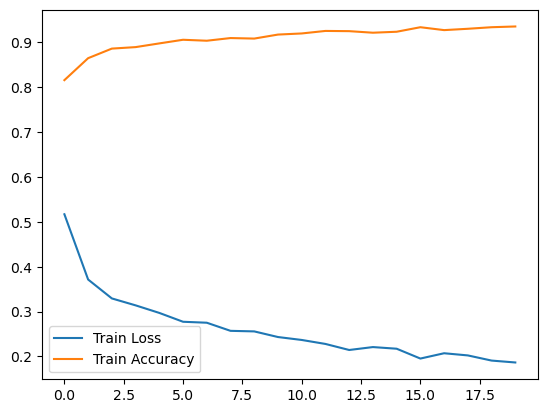

In [39]:
# Plot the loss and accuracy curves
plt.plot(train_losses, label='Train Loss')
plt.plot(train_accuracies, label='Train Accuracy')
plt.legend()
plt.show()

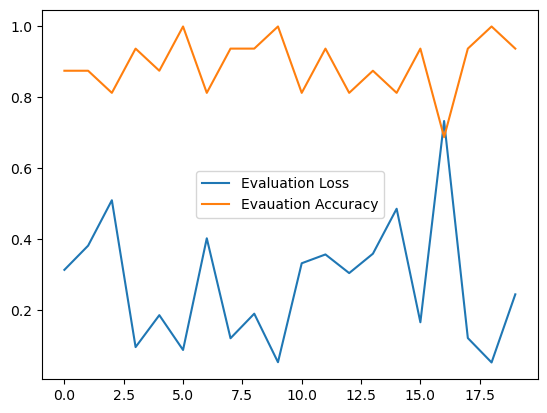

In [40]:
# Plot the loss and accuracy curves
plt.plot(val_losses, label='Evaluation Loss')
plt.plot(val_accuracies, label='Evauation Accuracy')
plt.legend()
plt.show()

In [41]:
#Lets define the function to predict the images from prediction set

from torch.autograd import Variable

def pred_class(img):
    # transform images
    img_tens = transform_tests(img)
    # change image format (3,300,300) to (1,3,300,300) by help of unsqueeze function
    # image needs to be in cuda before predition
    img_im = img_tens.unsqueeze(0).cuda() 
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model(uinput)
    # convert image to numpy format in cpu and snatching max prediction score class index
    index = out.data.cpu().numpy().argmax()    
    return index

In [42]:
#Lets get the location of all the prediction files
pred_files = [os.path.join(pred_data_dir, f) for f in os.listdir(pred_data_dir)]
pred_files[:10]

['/kaggle/input/deep-learning-for-msc-2022-23/test/14127.png',
 '/kaggle/input/deep-learning-for-msc-2022-23/test/11396.png',
 '/kaggle/input/deep-learning-for-msc-2022-23/test/14260.png',
 '/kaggle/input/deep-learning-for-msc-2022-23/test/12329.png',
 '/kaggle/input/deep-learning-for-msc-2022-23/test/13412.png',
 '/kaggle/input/deep-learning-for-msc-2022-23/test/14325.png',
 '/kaggle/input/deep-learning-for-msc-2022-23/test/13139.png',
 '/kaggle/input/deep-learning-for-msc-2022-23/test/12743.png',
 '/kaggle/input/deep-learning-for-msc-2022-23/test/14990.png',
 '/kaggle/input/deep-learning-for-msc-2022-23/test/10760.png']

In [43]:
#Prediction Results 
checkpoint=torch.load('bestModel.model2')
model=get_model()
model.load_state_dict(checkpoint)
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [44]:
predictions={}
predictions['Filename'] = 'Label'

for i, images in enumerate(pred_files):
    img = Image.open(images)
    index = pred_class(img)
    predictions[images[49:58]]=index
    
    
import csv

predictionFile = open("predictionsModel-2.csv", "w")

write = csv.writer(predictionFile)
for key, value in predictions.items():
    write.writerow([key, value])

predictionFile.close()